In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import itertools
import random

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2
import seaborn as sns

from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import Model
#from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.optimizers import Adam

from pathlib import Path
import os.path

from sklearn.metrics import classification_report, confusion_matrix

sns.set_style('darkgrid')

In [ ]:
import kagglehub

data_path = kagglehub.dataset_download("vencerlanz09/healthy-and-bleached-corals-image-classification")

In [ ]:
#seed everythign for future reproducability

def seed_everything(seed = 43):
  tf.random.set_seed(seed)

  np.random.seed(seed)

  random.seed(seed)

  #force tensorflow to use single thread
  #can't reproduce results with multiple threads

  session_conf = tf.compat.v1.ConfigProto(
      intra_op_parallelism_threads = 1,
      inter_op_parallelism_threads = 1
  )

  tf.compat.v1.set_random_seed(seed)

  sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
  k.set_session(sess)

#seed_everything()

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

--2025-04-19 13:32:37--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0.001s  

2025-04-19 13:32:37 (13.2 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
BATCH_SIZE =32
TARGET_SIZE = (224, 224)

In [ ]:
#dataset = "/kaggle/input/healthy-and-bleached-corals-image-classification"
dataset = data_path
walk_through_dir(dataset)

There are 2 directories and 0 images in '/kaggle/input/healthy-and-bleached-corals-image-classification'.
There are 0 directories and 438 images in '/kaggle/input/healthy-and-bleached-corals-image-classification/healthy_corals'.
There are 0 directories and 485 images in '/kaggle/input/healthy-and-bleached-corals-image-classification/bleached_corals'.


In [ ]:
#placing data into dataframe

def convert_data_to_df(dataset):
  image_dir = Path(dataset)

  filepaths = list(image_dir.glob(r'**/*.JPG'))+ list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.jpeg')) + list(image_dir.glob(r'**/*.PNG'))
  labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

  filepaths = pd.Series(filepaths, name='Filepath').astype(str)
  labels = pd.Series(labels, name='Label')

  image_df = pd.concat([filepaths,labels], axis=1)
  return image_df

image_df = convert_data_to_df(dataset)

In [ ]:
image_df.shape

(922, 2)

In [ ]:
#check for corrupted images in the dataset

import PIL
from pathlib import Path
from PIL import UnidentifiedImageError

path = Path(dataset).rglob("*.jpg")
for img_p in path:
  try:
    img = PIL.Image.open(img_p)
  except PIL.UnidentifiedImageError:
    print(img_p)

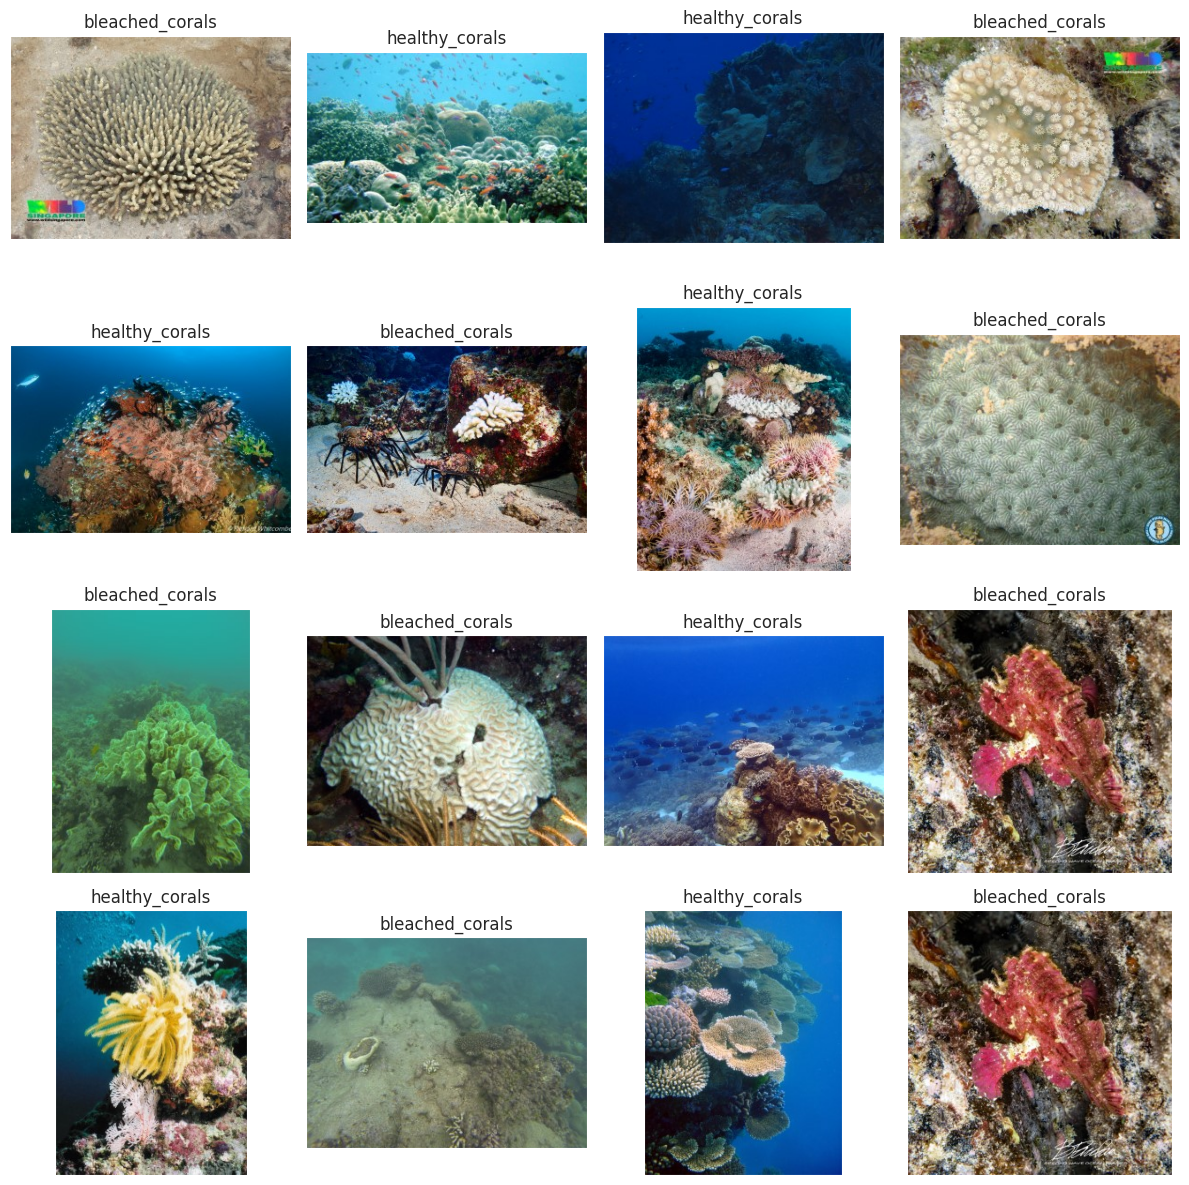

In [ ]:
random_index = np.random.randint(0,len(image_df), 16)
fig, axes = plt.subplots(nrows= 4, ncols=4, figsize=(12,12),
                        subplot_kw = {'xticks':[], 'yticks':[]})

for i, ax in enumerate(axes.flat):
  ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
  ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

In [ ]:
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42)

In [ ]:
train_df.shape

(737, 2)

In [ ]:
train_generator = ImageDataGenerator(
    preprocessing_function = tf.keras.applications.vgg19.preprocess_input,validation_split = 0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg19.preprocess_input
)

In [ ]:
# Split the data into three categories.
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=43,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=43,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 590 validated image filenames belonging to 2 classes.
Found 147 validated image filenames belonging to 2 classes.
Found 185 validated image filenames belonging to 2 classes.


In [ ]:
# Data Augmentation Step
augment = tf.keras.Sequential([
  layers.Resizing(224,224),
  layers.Rescaling(1./255),
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.1),
  layers.RandomZoom(0.1),
  layers.RandomContrast(0.1),
])

In [ ]:
#Load the pretrained model

pretrained_model = tf.keras.applications.vgg19.VGG19(
    input_shape = (224,224, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)

pretrained_model.trainable =False

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
inputs = pretrained_model.input
x = augment(inputs)

x = Dense(128, activation='relu')(pretrained_model.output)
x = BatchNormalization()(x)
x = Dropout(0.45)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.45)(x)


outputs = Dense(2, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=Adam(0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=10,
    callbacks=[
        #arly_stopping,
        create_tensorboard_callback("training_logs",
                                    "corals_classification"),
        #checkpoint_callback,
        #reduce_lr
    ]
)

Saving TensorBoard log files to: training_logs/corals_classification/20250419-141633
Epoch 1/10
14/19 ━━━━━━━━━━━━━━━━━━━━ 2:04 25s/step - accuracy: 0.4912 - loss: 1.3016

KeyboardInterrupt: 